# SMILE: Statistical Model-agnostic Interpretability with Local Explanations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

gray_cmap=LinearSegmentedColormap.from_list('gy',[(.3,.3,.3),(.8,.8,.8)], N=2) 
np.random.seed(222) #Seed for random numbers generation

def set_plot_style():
    plt.axis([-2,2,-2,2])
    plt.xlabel('x1')
    plt.ylabel('x2')

In [2]:
df = pd.read_csv("../input/smile-simple-test1/artificial_data.csv",header = 'infer')
df[0:5]

x1     x2  y
0  14.48  27.10  0
1  13.83  26.85  0
2  13.18  26.70  0
3  12.53  26.50  0
4  11.58  26.25  0

In [3]:
X = df[['x1','x2']].values
y = df['y'].values
X = (X - np.mean(X,axis=0)) / np.std(X,axis=0) #Standarization of data

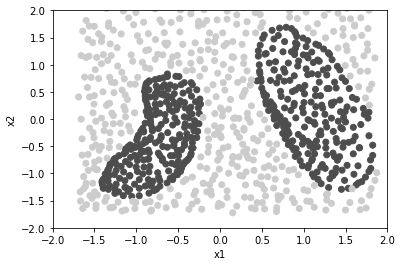

In [4]:
set_plot_style()
plt.scatter(X[:,0],X[:,1], c=y, cmap=gray_cmap)

In [5]:
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X, y) 

RandomForestClassifier()

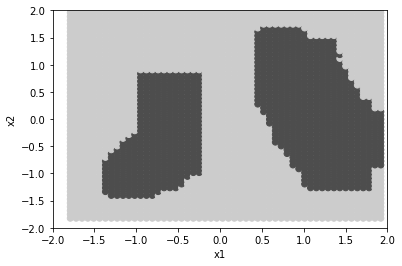

In [6]:
#Function to create a mesh grid
def make_meshgrid(x1, x2, h=.02,x1_min=0,x1_max=0,x2_min=0,x2_max=0):
    if x1_min==0 and x1_max==0 and x2_min==0 and x2_max==0:
        x1_min, x1_max = x1.min() - 0.1, x1.max() + 0.1
        x2_min, x2_max = x2.min() - 0.1, x2.max() + 0.1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
    return np.vstack((xx1.ravel(), xx2.ravel())).T

#Create mesh grid and predict class for each element in mesh grid
XX = make_meshgrid(X[:,0],X[:,1],h=.07)
yy = classifier.predict(XX)

set_plot_style()
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap)

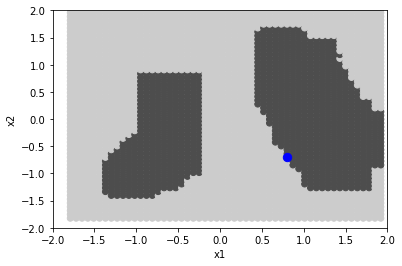

In [7]:
Xi = np.array([0.8,-0.7]) 
set_plot_style()
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap)
plt.scatter(Xi[0],Xi[1],c="blue",marker="o",s=70 )

array([1])

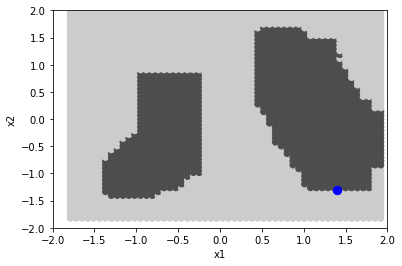

In [8]:
Xi3 = np.array([1.4,-1.3]) 
set_plot_style()
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap)
plt.scatter(Xi3[0],Xi3[1],c="blue",marker="o",s=70 )

classifier.predict(Xi3.reshape(1, -1))

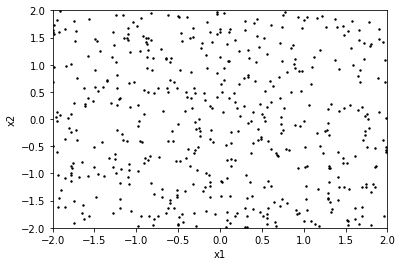

In [9]:
num_perturb = 500
#X_lime = np.random.normal(0,1,size=(num_perturb,X.shape[1]))
X_lime = np.random.uniform(-2,2,size=(num_perturb,X.shape[1]))

set_plot_style()
plt.scatter(X_lime[:,0],X_lime[:,1],s=2,c="black")

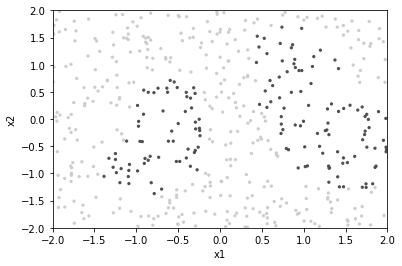

In [10]:
y_lime = classifier.predict(X_lime)
set_plot_style()
plt.scatter(X_lime[:,0],X_lime[:,1],s=5, c=y_lime, cmap=gray_cmap)

In [11]:
classifier.predict(np.array([0.8,-0.7]).reshape(1, -1) )

array([1])

In [12]:
kernel_width = 0.75
distances = np.sum((Xi - X_lime)**2,axis=1) #Euclidean distance
weights = np.sqrt(np.exp(-(distances**2)/(kernel_width**2))) #Kernel function
weights.shape

(500,)

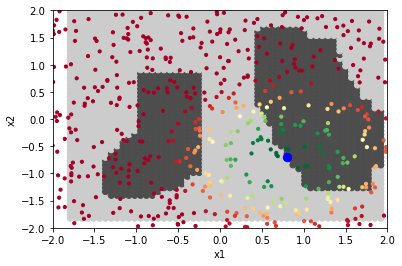

In [13]:
set_plot_style()
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap) 
plt.scatter(X_lime[:,0],X_lime[:,1],s=10,c= weights,cmap="RdYlGn") 
plt.scatter(Xi[0],Xi[1],c="blue",marker="o",s=70 )

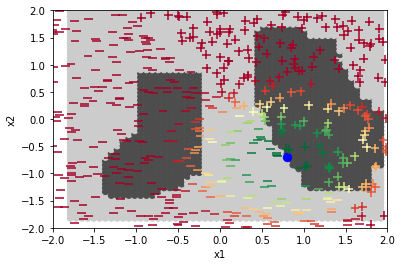

In [14]:
simpler_model = LinearRegression() 
simpler_model.fit(X_lime, y_lime, sample_weight=weights)
y_linmodel = simpler_model.predict(X_lime)
y_linmodel = y_linmodel < 0.5 #Conver to binary class

set_plot_style()
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap) 
plt.scatter(Xi[0],Xi[1],c="blue",marker="o",s=70 )
plt.scatter(X_lime[y_linmodel==0,0],X_lime[y_linmodel==0,1],c= weights[y_linmodel==0],cmap="RdYlGn",marker="_",s=80)
plt.scatter(X_lime[y_linmodel==1,0],X_lime[y_linmodel==1,1],c= weights[y_linmodel==1],cmap="RdYlGn",marker="+",s=80)

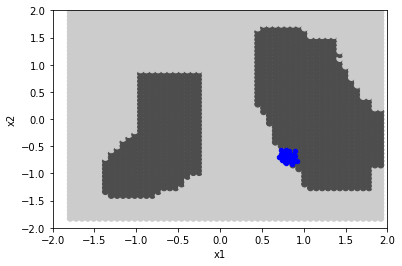

In [15]:
#koo
Xi2 = np.zeros((100,2))
Xi = np.array([0.8,-0.7]) 
Xi2[:,0] = Xi[0] + np.random.normal(0,0.05,100)
Xi2[:,1] = Xi[1] + np.random.normal(0,0.05,100)
set_plot_style()
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap)
plt.scatter(Xi2[:,0],Xi2[:,1],c="blue",marker="o",s=20 )

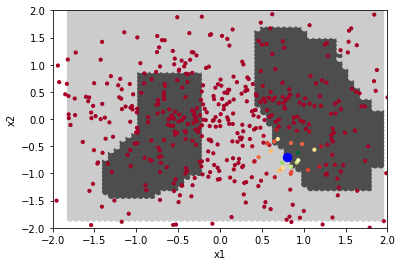

In [16]:
def Wasserstein_Dist(XX, YY):
    '''
    Wasserstein_Dist_PVal is for Wasserstein distance measure with Boostrap-based p-value calculation.
    The p-Value can be used to validate statistical distance measures.
    
    XX: The first input vector. It should be a numpy array with length of n.
    YY: The second input vector. It should be a numpy array with lenght of m.
    '''

    import numpy as np
    nx = len(XX)
    ny = len(YY)
    n = nx + ny

    XY = np.concatenate([XX,YY])
    X2 = np.concatenate([np.repeat(1/nx, nx), np.repeat(0, ny)])
    Y2 = np.concatenate([np.repeat(0, nx), np.repeat(1/ny, ny)])

    S_Ind = np.argsort(XY)
    XY_Sorted = XY[S_Ind]
    X2_Sorted = X2[S_Ind]
    Y2_Sorted = Y2[S_Ind]

    Res = 0
    E_CDF = 0
    F_CDF = 0
    power = 1

    for ii in range(0, n-2):
        E_CDF = E_CDF + X2_Sorted[ii]
        F_CDF = F_CDF + Y2_Sorted[ii]
        height = abs(F_CDF-E_CDF)
        width = XY_Sorted[ii+1] - XY_Sorted[ii]
        Res = Res + (height ** power) * width;  
 
    return Res

def  Wasserstein_Dist_PVal(XX, YY):
    '''
    Wasserstein_Dist_PVal is for Wasserstein distance measure with Boostrap-based p-value calculation.
    The p-Value can be used to validate statistical distance measures.
    
    XX: The first input vector. It should be a numpy array with length of n.
    YY: The second input vector. It should be a numpy array with lenght of m.
    '''
    
    import random
    nboots = 1000
    WD = Wasserstein_Dist(XX,YY)
    na = len(XX)
    nb = len(YY)
    n = na + nb
    comb = np.concatenate([XX,YY])
    reps = 0
    bigger = 0
    for ii in range(1, nboots):
        e = random.sample(range(n), na)
        f = random.sample(range(n), nb)
        boost_WD = Wasserstein_Dist(comb[e],comb[f]);
        if (boost_WD > WD):
            bigger = 1 + bigger
            
    pVal = bigger/nboots;

    return pVal, WD

def WasserstainLIME(X_input, num_perturb = 500, kernel_width2 = 0.2):

    num_perturb = 500
    X_lime = np.random.normal(0,1,size=(num_perturb,X.shape[1]))
    
    Xi2 = np.zeros((100,2))
    #Xi = np.array([0.8,-0.7]) 
    Xi2[:,0] = X_input[0] + np.random.normal(0,0.05,100)
    Xi2[:,1] = X_input[1] + np.random.normal(0,0.05,100)

    #kernel_width2 = 0.75

    y_lime2  = np.zeros((num_perturb,1))
    WD       = np.zeros((num_perturb,1))
    weights2 = np.zeros((num_perturb,1))

    for ind, ii in enumerate(X_lime):
        temp1 = ii[0] + np.random.normal(0,0.4,100)
        temp2 = ii[1] + np.random.normal(0,0.4,100)
        df2 = pd.DataFrame()
        df2['x1'] = temp1
        df2['x2'] = temp2
        temp3 = classifier.predict(df2)
        y_lime2[ind] = np.argmax(np.bincount(temp3))
        WD1 = Wasserstein_Dist(Xi2[:,0], df2[:]['x1'])
        WD2 = Wasserstein_Dist(Xi2[:,1], df2[:]['x2'])
        WD[ind] = sum([WD1, WD2])
    
        weights2[ind] = np.sqrt(np.exp(-(WD[ind]**2)/(kernel_width2**2))) 
    
    weights2 = weights2.flatten()
    
    simpler_model2 = LinearRegression() 
    simpler_model2.fit(X_lime, y_lime2, sample_weight=weights2)
    y_linmodel2 = simpler_model2.predict(X_lime)
    y_linmodel2 = y_linmodel2 < 0.5 #Conver to binary class
    y_linmodel2 = y_linmodel2.flatten()
    
    return X_lime, y_lime2, weights2, y_linmodel2, simpler_model2.coef_.flatten()
    
X_lime, y_lime2, weights2, y_linmodel2, WLIME_Coef = WasserstainLIME(Xi, num_perturb = 500, kernel_width2 = 0.2)
    
set_plot_style()
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap) 
plt.scatter(X_lime[:,0],X_lime[:,1],s=10,c= weights2,cmap="RdYlGn") 
plt.scatter(Xi[0],Xi[1],c="blue",marker="o",s=70 )

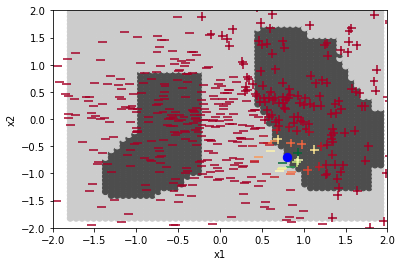

In [17]:
set_plot_style()
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap) 
plt.scatter(Xi[0],Xi[1],c="blue",marker="o",s=70 )
plt.scatter(X_lime[y_linmodel2==0,0],X_lime[y_linmodel2==0,1],c= weights2[y_linmodel2==0],cmap="RdYlGn",marker="_",s=80)
plt.scatter(X_lime[y_linmodel2==1,0],X_lime[y_linmodel2==1,1],c= weights2[y_linmodel2==1],cmap="RdYlGn",marker="+",s=80)

In [18]:
WLIME_Coef

array([-2.16352749, -0.85641536])

In [19]:
simpler_model.coef_.flatten()

array([-0.49990745, -0.3550739 ])

In [20]:
df3 = pd.DataFrame()
temp0 = np.zeros((2,2))

for ind, ii in enumerate(WLIME_Coef):
    #print(ii)
    if ii > 0:
        temp0[ind,1] = ii
    else:
        temp0[ind,0] = ii
df3['neg'] = temp0[:,0]
df3['pos'] = temp0[:,1]

import plotly.express as px
fig = px.bar(df3, x='neg', y=df3.index, orientation='h')
fig.show()

In [21]:
df3 = pd.DataFrame()
temp0 = np.zeros((2,2))

for ind, ii in enumerate(simpler_model.coef_.flatten()):
    #print(ii)
    if ii > 0:
        temp0[ind,1] = ii
    else:
        temp0[ind,0] = ii
df3['neg'] = temp0[:,0]
df3['pos'] = temp0[:,1]

import plotly.express as px
fig = px.bar(df3, x='neg', y=df3.index, orientation='h')
fig.show()

In [22]:
import shap
if 0:

    explainer = shap.Explainer(classifier)
    shap_values = explainer(Xi)

    #shap.plots.waterfall(shap_values[0])
    shap.plots.bar(shap_values[1])

In [23]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X, feature_names=df3.columns, kernel_width=0.75, discretize_continuous=True)

exp = explainer.explain_instance(Xi, classifier.predict_proba, num_features=2, top_labels=2)

exp.show_in_notebook(show_table=True, show_all=False)

### Another Example

(500,)
[-0.34595162 -0.96348696]


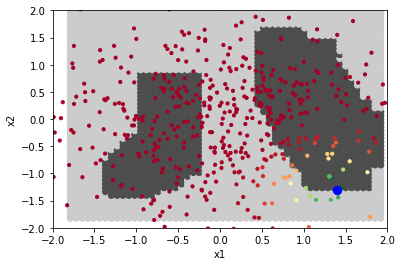

In [24]:
X_lime, y_lime2, weights2, y_linmodel2, WLIME_Coef = WasserstainLIME(Xi3, num_perturb = 500, kernel_width2 = 0.5)
print(weights2.shape)
print(WLIME_Coef)
    
set_plot_style()
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap) 
plt.scatter(X_lime[:,0],X_lime[:,1],s=10,c= weights2,cmap="RdYlGn") 
plt.scatter(Xi3[0],Xi3[1],c="blue",marker="o",s=70 )

## BOSTON Example

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


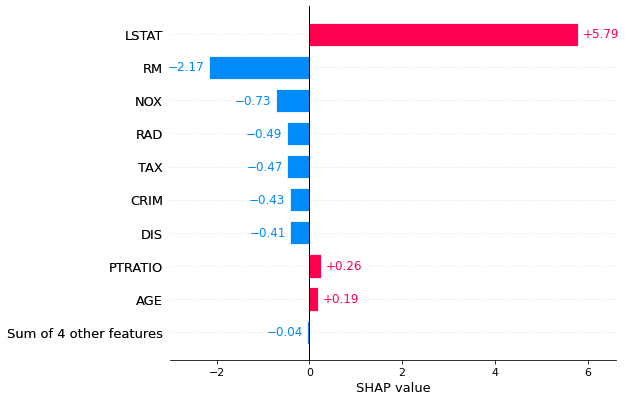

In [25]:
import xgboost
import shap

# train an XGBoost model
X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
#shap.plots.waterfall(shap_values[0])
shap.plots.bar(shap_values[0])

In [26]:
X

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0    0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1    0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2    0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3    0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4    0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
501  0.06263   0.0  11.93   0.0  0.573  6.593  69.1  2.4786  1.0  273.0   
502  0.04527   0.0  11.93   0.0  0.573  6.120  76.7  2.2875  1.0  273.0   
503  0.06076   0.0  11.93   0.0  0.573  6.976  91.0  2.1675  1.0  273.0   
504  0.10959   0.0  11.93   0.0  0.573  6.794  89.3  2.3889  1.0  273.0   
505  0.04741   0.0  11.93   0.0  0.573  6.030  80.8  2.5050  1.0  273.0   

     PTRATIO       B  LSTAT  
0       15.3  396.90   4.98  
1       17.8  396.90   9.14  
2       17.8  392.83   4.03  
3       18.7  394.63   2.94  
4       18.7  396.90   5.33  
..       ...     ...    ...  
501     21.0  391.99   9.67  
502     21.0  396.90   9.08  
503     21.0  396.90   5.64  
504     21.0  393.45   6.48  
505     21.0  396.90   7.88  

[506 rows x 13 columns]

In [27]:
def Wasserstein_Dist(XX, YY):
  
    import numpy as np
    nx = len(XX)
    ny = len(YY)
    n = nx + ny

    XY = np.concatenate([XX,YY])
    X2 = np.concatenate([np.repeat(1/nx, nx), np.repeat(0, ny)])
    Y2 = np.concatenate([np.repeat(0, nx), np.repeat(1/ny, ny)])

    S_Ind = np.argsort(XY)
    XY_Sorted = XY[S_Ind]
    X2_Sorted = X2[S_Ind]
    Y2_Sorted = Y2[S_Ind]

    Res = 0
    E_CDF = 0
    F_CDF = 0
    power = 1

    for ii in range(0, n-2):
        E_CDF = E_CDF + X2_Sorted[ii]
        F_CDF = F_CDF + Y2_Sorted[ii]
        height = abs(F_CDF-E_CDF)
        width = XY_Sorted[ii+1] - XY_Sorted[ii]
        Res = Res + (height ** power) * width;  
 
    return Res

def  Wasserstein_Dist_PVal(XX, YY):
    
    import random
    nboots = 1000
    WD = Wasserstein_Dist(XX,YY)
    na = len(XX)
    nb = len(YY)
    n = na + nb
    comb = np.concatenate([XX,YY])
    reps = 0
    bigger = 0
    for ii in range(1, nboots):
        e = random.sample(range(n), na)
        f = random.sample(range(n), nb)
        boost_WD = Wasserstein_Dist(comb[e],comb[f]);
        if (boost_WD > WD):
            bigger = 1 + bigger
            
    pVal = bigger/nboots;

    return pVal, WD

def WasserstainLIME(X_input, num_perturb = 500, L_num_perturb = 100, kernel_width2 = 0.75, model = model, epsilon = 0.1):
    '''
    WasserstainLIME is a statistical version of LIME (local interpretable model-agnostic explanations) 
    in which instead of Euclidean distance, the ECDF-based distance is used.
    
    X_input: should be a numpy array that represents one point in a n-dimensional space.
    
    num_perturb: Is the number of perturbations that the algorithm uses.
    
    L_num_perturb: Is the number of perturbations in the local areas that the algorithm uses.
    
    kernel_width: Is the Kernel Width. When the decision space is very dynamic, the kernel width should be low like 0.2, 
    otherwise kernel with around 0.75 would be ideal.
    
    model: It is the trained model that can be for a classification or regression. 
    
    epsilon: It is used to normalize the WD values.
    
    '''
    
    X_input = (X_input - np.mean(X_input,axis=0)) / np.std(X_input,axis=0) #Standarization of data

    X_lime = np.random.normal(0,1,size=(num_perturb,X_input.shape[0]))
    
    Xi2 = np.zeros((L_num_perturb,X_input.shape[0]))
    
    for jj in range(X_input.shape[0]):
        Xi2[:,jj] = X_input[jj] + np.random.normal(0,0.05,L_num_perturb)

    y_lime2  = np.zeros((num_perturb,1))
    WD       = np.zeros((num_perturb,1))
    weights2 = np.zeros((num_perturb,1))
    
    for ind, ii in enumerate(X_lime):
        
        df2 = pd.DataFrame()
        
        for jj in range(X_input.shape[0]):
            temp1 = ii[jj] + np.random.normal(0,0.3,L_num_perturb)
            df2[len(df2.columns)] = temp1

        temp3 = model.predict(df2)

        y_lime2[ind] = np.mean(temp3)  # For classification: np.argmax(np.bincount(temp3))
        
        WD1 = np.zeros((X_input.shape[0],1))
        
        df2 = df2.to_numpy()
        
        for kk in range(X_input.shape[0]):
            #print( df2.shape)
            WD1[kk] = Wasserstein_Dist(Xi2[:,kk], df2[:,kk])
        
        #print(WD1)
        #print(ind)
        WD[ind] = sum(WD1)
        #print(WD)
    
        weights2[ind] = np.sqrt(np.exp(-((epsilon*WD[ind])**2)/(kernel_width2**2))) 
        #print(weights2[ind])
        
        del df2
    
    weights2 = weights2.flatten()
    #print(weights2)
    
    simpler_model2 = LinearRegression() 
    simpler_model2.fit(X_lime, y_lime2, sample_weight=weights2)
    y_linmodel2 = simpler_model2.predict(X_lime)
    y_linmodel2 = y_linmodel2 < 0.5 #Conver to binary class
    y_linmodel2 = y_linmodel2.flatten()
    
    return X_lime, y_lime2, weights2, y_linmodel2, simpler_model2.coef_.flatten()

X2 = X.copy()
    
X_lime, y_lime2, weights2, y_linmodel2, WLIME_Coef = WasserstainLIME(X2.loc[0].to_numpy(), num_perturb = 5000, kernel_width2 = 0.5, model = model, epsilon = 0.3)

#print(WLIME_Coef)

df3 = pd.DataFrame()
temp0 = np.zeros((2,2))

df3['WDL'] = WLIME_Coef 
df3['feature_names'] = shap_values[0].feature_names

import plotly.express as px
fig = px.bar(df3, x='WDL', y='feature_names', orientation='h', color='feature_names')
fig.show()

In [28]:
import plotly.graph_objects as go

fig = go.Figure(go.Waterfall(
    name = "20", 
                             orientation = "h",
    #measure = ["relative", "relative", "total", "relative", "relative", "total"],
    x = df3['WDL'],
    textposition = "outside",
    #text = [str(df3['WDL'])],
    y = df3['feature_names'],
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
        title = "Wasserstain LIME Explanability",
        showlegend = True
)

fig.show()

## Comparing with LIME

In [29]:
import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
import lime
import lime.lime_tabular
#from __future__ import print_function
np.random.seed(1)

iris = sklearn.datasets.load_iris()
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(iris.data, iris.target, train_size=0.80)
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train, labels_train)
sklearn.metrics.accuracy_score(labels_test, rf.predict(test))

explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=iris.feature_names, class_names=iris.target_names, discretize_continuous=True)

i = np.random.randint(0, test.shape[0])
exp = explainer.explain_instance(test[i], rf.predict_proba, num_features=4, top_labels=1)

exp.show_in_notebook(show_table=True, show_all=False)

In [30]:
X_lime, y_lime2, weights2, y_linmodel2, WLIME_Coef = WasserstainLIME(train[0], num_perturb = 5000, kernel_width2 = 0.5, model = rf, epsilon = 0.3)

In [31]:
df3 = pd.DataFrame()
temp0 = np.zeros((2,2))

df3['WDL'] = WLIME_Coef 
df3['feature_names'] = iris.feature_names

import plotly.express as px
fig = px.bar(df3, x='WDL', y='feature_names', orientation='h', color='feature_names')
fig.show()

## Fooling LIME and SHAP: Adversarial Attacks on Post hoc Explanation Methods
Source: [https://github.com/dylan-slack/Fooling-LIME-SHAP](https://github.com/dylan-slack/Fooling-LIME-SHAP)
Paper: [Fooling LIME and SHAP: Adversarial Attacks on Post hoc Explanation Methods](https://arxiv.org/pdf/1911.02508.pdf)

In [32]:
!git clone https://github.com/dylan-slack/Fooling-LIME-SHAP.git -quite

In [33]:
import sys
sys.path.insert(1, '/kaggle/working/Fooling-LIME-SHAP')

In [34]:
import warnings
warnings.filterwarnings('ignore') 

from adversarial_models import * 
from utils import *
from get_data import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

import lime
import lime.lime_tabular
import shap
from copy import deepcopy

In [35]:
def get_and_preprocess_compas_data(params):
    """Handle processing of COMPAS according to: https://github.com/propublica/compas-analysis

    Parameters
    ----------
    params : Params
    Returns
    ----------
    Pandas data frame X of processed data, np.ndarray y, and list of column names
    """
    PROTECTED_CLASS = params.protected_class
    UNPROTECTED_CLASS = params.unprotected_class
    POSITIVE_OUTCOME = params.positive_outcome
    NEGATIVE_OUTCOME = params.negative_outcome

    compas_df = pd.read_csv("./Fooling-LIME-SHAP/data/compas-scores-two-years.csv", index_col=0)
    compas_df = compas_df.loc[(compas_df['days_b_screening_arrest'] <= 30) &
                              (compas_df['days_b_screening_arrest'] >= -30) &
                              (compas_df['is_recid'] != -1) &
                              (compas_df['c_charge_degree'] != "O") &
                              (compas_df['score_text'] != "NA")]

    compas_df['length_of_stay'] = (
                pd.to_datetime(compas_df['c_jail_out']) - pd.to_datetime(compas_df['c_jail_in'])).dt.days
    X = compas_df[['age', 'two_year_recid', 'c_charge_degree', 'race', 'sex', 'priors_count', 'length_of_stay']]

    # if person has high score give them the _negative_ model outcome
    y = np.array([NEGATIVE_OUTCOME if score == 'High' else POSITIVE_OUTCOME for score in compas_df['score_text']])
    sens = X.pop('race')

    # assign African-American as the protected class
    X = pd.get_dummies(X)
    sensitive_attr = np.array(pd.get_dummies(sens).pop('African-American'))
    X['race'] = sensitive_attr

    # make sure everything is lining up
    assert all((sens == 'African-American') == (X['race'] == PROTECTED_CLASS))
    cols = [col for col in X]

    return X, y, cols


def get_and_preprocess_cc(params):
    """"Handle processing of Communities and Crime.  We exclude rows with missing values and predict
    if the violent crime is in the 50th percentile.
    Parameters
    ----------
    params : Params
    Returns:
    ----------
    Pandas data frame X of processed data, np.ndarray y, and list of column names
    """
    PROTECTED_CLASS = params.protected_class
    UNPROTECTED_CLASS = params.unprotected_class
    POSITIVE_OUTCOME = params.positive_outcome
    NEGATIVE_OUTCOME = params.negative_outcome

    X = pd.read_csv("./Fooling-LIME-SHAP/data/communities_and_crime_new_version.csv", index_col=0)

    # everything over 50th percentil gets negative outcome (lots of crime is bad)
    high_violent_crimes_threshold = 50
    y_col = 'ViolentCrimesPerPop numeric'

    X = X[X[y_col] != "?"]
    X[y_col] = X[y_col].values.astype('float32')

    # just dump all x's that have missing values 
    cols_with_missing_values = []
    for col in X:
        if len(np.where(X[col].values == '?')[0]) >= 1:
            cols_with_missing_values.append(col)

    y = X[y_col]
    y_cutoff = np.percentile(y, high_violent_crimes_threshold)
    X = X.drop(
        cols_with_missing_values + ['communityname string', 'fold numeric', 'county numeric', 'community numeric',
                                    'state numeric'] + [y_col], axis=1)

    # setup ys
    cols = [c for c in X]
    y = np.array([NEGATIVE_OUTCOME if val > y_cutoff else POSITIVE_OUTCOME for val in y])

    return X, y, cols

In [36]:
# Get the data set and do some preprocessing
params = Params("./Fooling-LIME-SHAP/model_configurations/experiment_params.json") 
np.random.seed(params.seed)
X, y, cols = get_and_preprocess_compas_data(params)

# Add a random column -- this is what we'll have LIME/SHAP explain.
X['unrelated_column'] = np.random.choice([0,1],size=X.shape[0])
features = [c for c in X]

categorical_feature_name = ['two_year_recid', 'c_charge_degree_F', 'c_charge_degree_M',\
                            'sex_Female', 'sex_Male', 'race', 'unrelated_column']

categorical_feature_indcs = [features.index(c) for c in categorical_feature_name]

race_indc = features.index('race')
unrelated_indcs = features.index('unrelated_column')
X = X.values

In [37]:

class racist_model_f:
    # Decision rule: classify negatively if race is black
    def predict(self,X):
        return np.array([params.negative_outcome if x[race_indc] > 0 else params.positive_outcome for x in X])

    def predict_proba(self, X): 
        return one_hot_encode(self.predict(X))

    def score(self, X,y):
        return np.sum(self.predict(X)==y) / len(X)
    
class innocuous_model_psi:
    # Decision rule: classify according to randomly drawn column 'unrelated column'
    def predict(self,X):
        return np.array([params.negative_outcome if x[unrelated_indcs] > 0 else params.positive_outcome for x in X])

    def predict_proba(self, X): 
        return one_hot_encode(self.predict(X))

    def score(self, X,y):
        return np.sum(self.predict(X)==y) / len(X)

In [38]:
# Split the data and normalize
xtrain,xtest,ytrain,ytest = train_test_split(X,y)
xtest_not_normalized = deepcopy(xtest)
ss = StandardScaler().fit(xtrain)
xtrain = ss.transform(xtrain)
xtest = ss.transform(xtest)

# Train the adversarial model for LIME with f and psi 
adv_lime = Adversarial_Lime_Model(racist_model_f(), innocuous_model_psi()).\
            train(xtrain, ytrain, feature_names=features, categorical_features=categorical_feature_indcs)

In [39]:
# Let's just look at a the first example in the test set
ex_indc = np.random.choice(xtest.shape[0])

# To get a baseline, we'll look at LIME applied to the biased model f
normal_explainer = lime.lime_tabular.LimeTabularExplainer(xtrain,feature_names=adv_lime.get_column_names(),
                                                          discretize_continuous=False,
                                                          categorical_features=categorical_feature_indcs)

normal_exp = normal_explainer.explain_instance(xtest[ex_indc], racist_model_f().predict_proba).as_list()

print ("Explanation on biased f:\n",normal_exp[:3],"\n\n")

# Now, lets look at the explanations on the adversarial model 
adv_explainer = lime.lime_tabular.LimeTabularExplainer(xtrain,feature_names=adv_lime.get_column_names(), 
                                                       discretize_continuous=False,
                                                       categorical_features=categorical_feature_indcs)

adv_exp = adv_explainer.explain_instance(xtest[ex_indc], adv_lime.predict_proba).as_list()

print ("Explanation on adversarial model:\n",adv_exp[:3],"\n")

print("Prediction fidelity: {0:3.2}".format(adv_lime.fidelity(xtest[ex_indc:ex_indc+1])))

Explanation on biased f:
 [('race=0', -0.9986343456272184), ('sex_Female=0', 2.0027981228433426e-05), ('unrelated_column=0', -1.7913202734343337e-05)] 


Explanation on adversarial model:
 [('unrelated_column=0', -0.9981443627773983), ('sex_Male=0', 0.0012015987966745123), ('two_year_recid=1', -0.0005130675716729507)] 

Prediction fidelity: 1.0


In [40]:
# Train the adversarial model
adv_shap = Adversarial_Kernel_SHAP_Model(racist_model_f(), innocuous_model_psi()).\
            train(xtrain, ytrain, feature_names=features)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

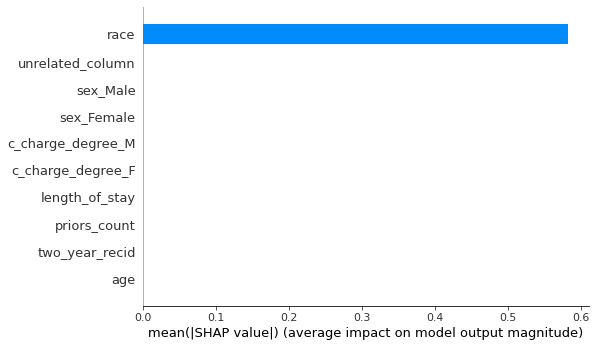

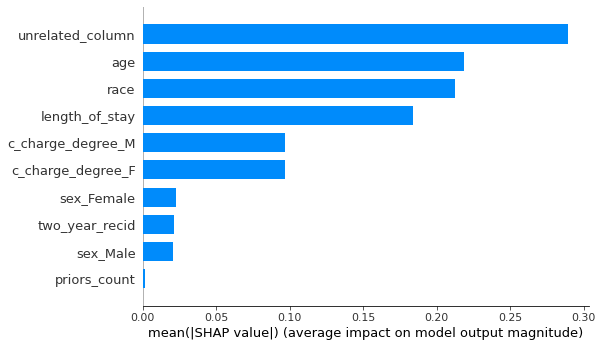

Fidelity: 1.0


In [41]:
# Set the background distribution for the shap explainer using kmeans
background_distribution = shap.kmeans(xtrain,10)

# Let's use the shap kernel explainer and grab a point to explain
to_examine = np.random.choice(xtest.shape[0])

# Explain the biased model
biased_kernel_explainer = shap.KernelExplainer(racist_model_f().predict, background_distribution)
biased_shap_values = biased_kernel_explainer.shap_values(xtest[to_examine:to_examine+1])

# Explain the adversarial model
adv_kerenel_explainer = shap.KernelExplainer(adv_shap.predict, background_distribution)
adv_shap_values = adv_kerenel_explainer.shap_values(xtest[to_examine:to_examine+1])

# Plot it using SHAP's plotting features.
shap.summary_plot(biased_shap_values, feature_names=features, plot_type="bar")
shap.summary_plot(adv_shap_values, feature_names=features, plot_type="bar")

print ("Fidelity: {0:3.2}".format(adv_shap.fidelity(xtest[to_examine:to_examine+1])))

In [42]:
def WasserstainLIME2(X_input, num_perturb = 500, L_num_perturb = 100, kernel_width2 = 0.75, model = model, epsilon = 0.1):
    '''
    WasserstainLIME is a statistical version of LIME (local interpretable model-agnostic explanations) 
    in which instead of Euclidean distance, the ECDF-based distance is used.
    
    X_input: should be a numpy array that represents one point in a n-dimensional space.
    
    num_perturb: Is the number of perturbations that the algorithm uses.
    
    L_num_perturb: Is the number of perturbations in the local areas that the algorithm uses.
    
    kernel_width: Is the Kernel Width. When the decision space is very dynamic, the kernel width should be low like 0.2, 
    otherwise kernel with around 0.75 would be ideal.
    
    model: It is the trained model that can be for a classification or regression. 
    
    epsilon: It is used to normalize the WD values.
    
    '''
    
    X_input = (X_input - np.mean(X_input,axis=0)) / np.std(X_input,axis=0) #Standarization of data

    X_lime = np.random.normal(0,1,size=(num_perturb,X_input.shape[0]))
    
    Xi2 = np.zeros((L_num_perturb,X_input.shape[0]))
    
    for jj in range(X_input.shape[0]):
        Xi2[:,jj] = X_input[jj] + np.random.normal(0,0.05,L_num_perturb)

    y_lime2  = np.zeros((num_perturb,1))
    WD       = np.zeros((num_perturb,1))
    weights2 = np.zeros((num_perturb,1))
    
    for ind, ii in enumerate(X_lime):
        
        df2 = pd.DataFrame()
        
        for jj in range(X_input.shape[0]):
            temp1 = ii[jj] + np.random.normal(0,0.3,L_num_perturb)
            df2[len(df2.columns)] = temp1

        temp3 = model.predict(df2.to_numpy())

        y_lime2[ind] = np.mean(temp3)  # For classification: np.argmax(np.bincount(temp3))
        
        WD1 = np.zeros((X_input.shape[0],1))
        
        df2 = df2.to_numpy()
        
        for kk in range(X_input.shape[0]):
            #print( df2.shape)
            WD1[kk] = Wasserstein_Dist(Xi2[:,kk], df2[:,kk])
        
        #print(WD1)
        #print(ind)
        WD[ind] = sum(WD1)
        #print(WD)
    
        weights2[ind] = np.sqrt(np.exp(-((epsilon*WD[ind])**2)/(kernel_width2**2))) 
        #print(weights2[ind])
        
        del df2
    
    weights2 = weights2.flatten()
    #print(weights2)
    
    simpler_model2 = LinearRegression() 
    simpler_model2.fit(X_lime, y_lime2, sample_weight=weights2)
    y_linmodel2 = simpler_model2.predict(X_lime)
    y_linmodel2 = y_linmodel2 < 0.5 #Conver to binary class
    y_linmodel2 = y_linmodel2.flatten()
    
    return X_lime, y_lime2, weights2, y_linmodel2, simpler_model2.coef_.flatten()

In [43]:
X_lime, y_lime2, weights2, y_linmodel2, WLIME_Coef = WasserstainLIME2(xtest[to_examine:to_examine+1].flatten(), 
                                                                      num_perturb = 2000, 
                                                                      kernel_width2 = 0.5, 
                                                                      L_num_perturb = 500,
                                                                      model = racist_model_f(), 
                                                                      epsilon = 0.3)



df3 = pd.DataFrame()
temp0 = np.zeros((2,2))

df3['WDL'] = WLIME_Coef 
df3['feature_names'] = features

import plotly.express as px
fig = px.bar(df3, x='WDL', y='feature_names', orientation='h', color='feature_names')
fig.show()

In [44]:
X_lime, y_lime2, weights2, y_linmodel2, WLIME_Coef = WasserstainLIME2(xtest[to_examine:to_examine+1].flatten(), 
                                                                      num_perturb = 500, 
                                                                      kernel_width2 = 0.75, 
                                                                      model = adv_shap, 
                                                                      epsilon = 0.3)
#print(WLIME_Coef)

df3 = pd.DataFrame()
temp0 = np.zeros((2,2))

df3['WDL'] = WLIME_Coef 
df3['feature_names'] = features

import plotly.express as px
fig = px.bar(df3, x='WDL', y='feature_names', orientation='h', color='feature_names')
fig.show()

In [45]:
from bayes_opt import BayesianOptimization as BO

def wlime_eval(num_perturb, kernel_width2, L_num_perturb,  epsilon, model = adv_shap, X = xtest[to_examine:to_examine+1].flatten()):
    
    X_lime, y_lime2, weights2, y_linmodel2, WLIME_Coef = WasserstainLIME2(X, num_perturb, L_num_perturb, kernel_width2, model,  epsilon)
        
    return 1/WLIME_Coef[-1]


def run_bayes_opt(eval_func):
    '''
    This function is to run Bayesian optimization. 
    'init_points' is the number of initializations - random search.
    'n_iter' is the number of iterations after your random initializations.
    '''
    
    
    param_space = {
        'num_perturb': (200, 1000),
        'kernel_width2': (0.2, 0.8),
        'L_num_perturb': (200, 1000),
        'epsilon': (0.1, 0.3),
    }
    
    bo = BO(eval_func, param_space)
    
    n_iter = 10
    init_points = 10
    
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        
        bo.maximize(init_points = init_points,
                   n_iter = n_iter,
                   acq = 'ucb',
                   alpha = 1e-6)
        
    return bo

In [46]:
#res_bo = run_bayes_opt(wlime_eval)
#max_bo_params = res_bo.max['params']